# Eat.Sleep.Data.  - Airbnb Price Predictor Analysis</br>
Team: Alex Conerly, Alex Felice, Betsy Wellington, Hannah Koivisto, Ken Liew, Whitney Losinski
<hr></hr>

## Cleaning and pre-processing the data
### Importing the libraries and data

In [1]:
# Import dependencies
import pandas as pd
import numpy as np

In [2]:
# Download calendar raw data from postgres for stage 1 ETL
list_data = pd.read_csv("../Resources/listings_full.csv")
pd.set_option('display.max_columns', len(list_data.columns))
pd.set_option('display.max_rows', 100)
list_data.head(5)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,6422,https://www.airbnb.com/rooms/6422,20190117134323,2019-01-17,Nashville Charm,"NOTE: For April and early May, must book at le...",1920 historic bungalow backs up to city park w...,"NOTE: For April and early May, must book at le...",none,Historic East Nashville is home to many new an...,We believe in radical hospitality which is why...,There is a bus stop 3 doors away (#4 Shelby) t...,"Access to the rest of the house, including Liv...",As much or as little as you want- just let us ...,"Respect yourself, respect others, respect the ...",NaN,NaN,https://a0.muscache.com/im/pictures/572c2654-f...,NaN,12172,https://www.airbnb.com/users/show/12172,Michele,2009-04-03,"Nashville, Tennessee, United States",My husband and I are parents of 5 grown childr...,within a few hours,100%,NaN,t,https://a0.muscache.com/im/users/12172/profile...,https://a0.muscache.com/im/users/12172/profile...,NaN,1,1,"['email', 'phone', 'reviews', 'kba']",t,t,"Nashville, TN, United States",NaN,District 6,NaN,Nashville,TN,37206,Nashville,"Nashville, TN",US,United States,36.173151,-86.735813,t,House,Private room,2,1.0,2,3.0,Real Bed,"{TV,Internet,Wifi,""Air conditioning"",Kitchen,""...",NaN,$40.00,NaN,NaN,NaN,NaN,1,$0.00,1,730,1,1,730,730,1.0,730.0,6 days ago,t,1,7,10,133,2019-01-17,561,131,2009-04-30,2019-01-13,99.0,10.0,10.0,10.0,10.0,10.0,10.0,f,NaN,"{""Tennessee State""}",f,f,strict_14_with_grace_period,f,f,1,0,1,0,4.74
1,20847,https://www.airbnb.com/rooms/20847,20190117134323,2019-01-17,East Nashville Retro Ranch!,Retro Ranch is nestled in the eclectic East si...,-Retro Ranch is nestled in a quiet part of Sou...,Retro Ranch is nestled in the eclectic East si...,none,"Many local favorites, including live music, th...","If you run, walk or bike, there is a lovely pa...",Uber & Lyft: Get rides from locals. More reli...,AMENITIES: -A healthy breakfast with French p...,Guest interaction is all about you! Whether yo...,Greetings! Check-in: 4pm-7pm* Check-out: 11am ...,NaN,NaN,https://a0.muscache.com/im/pictures/36034958/8...,NaN,79021,https://www.airbnb.com/users/show/79021,Kristina,2010-02-08,"Nashville, Tennessee, United States",I have been an Airbnb host in Nashville for 9 ...,within an hour,100%,NaN,t,https://a0.muscache.com/im/users/79021/profile...,htt

### Dropping initial columns from listings_full.csv

Looking at the raw data, we can see that there are several columns of data that will need to be dropped prior to any analysis.  Below are the reasons for dropping each column.

1. The following columns are all descriptive variables and we are not using NLP to build our model so they will be deleted.
    - name, summary, space, description, neighborhood_overview, notes, transit, access, interaction, house_rules


2. The following columns are not useful for predicting price as they are not features that are related to the property itself but rather the host or the listing details.
    - scrape_id, listing_url, thumbnail_url, medium_url, picture_url, xl_picture_url, host_id, host_url, host_name, host_location, host_about, host_thumbnail_url, host_picture_url, host_neighbourhood, host_verifications, calendar_updated, calendar_last_scraped


3. The following columns all deal with location but we are keeping lat/long and neighborhood cleansed for later use in our model and to determine neighborhood so we don't need the other location identifiers.  We are also only using data for Nashville, TN so the city, state and country columns are irrelevant.
    - street, neighbourhood, neighborhood_group_cleansed, city, state, zipcode, market, smart_location, country_code, country, is_location_exact, jurisdiction_names


4. Amenities will be parsed in a separate table so it will be deleted from the current dataset.


5. Extra_people will be dropped because it is an add-on to our target variable.  The price we are using as our target is not representative of the price if the user adds guests to the room.  Therefore, this column will be deleted.

6. First_review and last_review are date columns that aren't 

In [3]:
# Make a list of columns that will not be used in the analysis
columns_to_drop = list_data[['listing_url', 'scrape_id', 'name', 'summary', 'space', 'description', 'neighborhood_overview', 'notes', 'transit', 'access', 'interaction', 'house_rules', 'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_location', 'host_about', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host_verifications', 'street', 'neighbourhood', 'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market','smart_location', 'country_code', 'country', 'is_location_exact', 'amenities', 'calendar_updated', 'calendar_last_scraped', 'extra_people', 'jurisdiction_names']]

In [4]:
# Drop columns that will not be used in the analysis
list_data_new = list_data.drop(columns=columns_to_drop)
list_data_new.shape

(5998, 65)

Checking for NaN rows shows that there are a few columns that need to be dropped.  Since there are 5998 rows in the dataset, anything with over 5000 rows is of no use and will be dropped.  host_response_time and host_response_rate had 1700 NaN values and the team also chose to drop those columns rather than lose 1700 rows of data.

In [5]:
# View how many NaNs are in each column.
list_data_new.isna().sum()

id                                                 0
last_scraped                                       0
experiences_offered                                0
host_since                                         0
host_response_time                              1700
host_response_rate                              1700
host_acceptance_rate                            5998
host_is_superhost                                  0
host_listings_count                                0
host_total_listings_count                          0
host_has_profile_pic                               0
host_identity_verified                             0
neighbourhood_cleansed                             0
latitude                                           0
longitude                                          0
property_type                                      0
room_type                                          0
accommodates                                       0
bathrooms                                     

In [6]:
# Drop columns with mostly NaNs
list_data_new = list_data_new.drop(columns=['host_acceptance_rate', 'host_response_time', 'host_response_rate', 'license', 'square_feet', 'weekly_price', 'monthly_price'])

In [7]:
#  replace all NaNs in review columns with 0 - note there are no real 0 reviews and there is a variable is_review to identify the fake 0 values
cols=['security_deposit', 'cleaning_fee']
list_data_new[cols]=list_data_new[cols].fillna(0)

Host_total_listings_count is redundant to host_lisings_count.  The columns are identical so we will delete host_total_listings_count.  There are also several calculated host listings count columns which break down the listings by room type.  These will be highly correlated with host_listings_count and will negatively impact the model, so those columns will be dropped as well.

In [8]:
# Verify if host_total_listings_count and host_listings_count are the same.
host_listing_count_df = list_data_new.loc[((list_data_new['host_total_listings_count'] == list_data_new['host_listings_count']) == False)]
print(host_listing_count_df.shape)

(0, 58)


In [9]:
# Drop calculated host_listings_count columns
list_data_new = list_data_new.drop(columns=['host_total_listings_count', 'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms'])

Plotting the number of occurrences of each value for numerical and boolean categories shows that there are a number of columns with only one variable.  These columns will all be dropped.

array([[<AxesSubplot:title={'center':'id'}>,
        <AxesSubplot:title={'center':'host_is_superhost'}>,
        <AxesSubplot:title={'center':'host_listings_count'}>,
        <AxesSubplot:title={'center':'host_has_profile_pic'}>,
        <AxesSubplot:title={'center':'host_identity_verified'}>,
        <AxesSubplot:title={'center':'latitude'}>],
       [<AxesSubplot:title={'center':'longitude'}>,
        <AxesSubplot:title={'center':'accommodates'}>,
        <AxesSubplot:title={'center':'bathrooms'}>,
        <AxesSubplot:title={'center':'bedrooms'}>,
        <AxesSubplot:title={'center':'beds'}>,
        <AxesSubplot:title={'center':'guests_included'}>],
       [<AxesSubplot:title={'center':'minimum_nights'}>,
        <AxesSubplot:title={'center':'maximum_nights'}>,
        <AxesSubplot:title={'center':'minimum_minimum_nights'}>,
        <AxesSubplot:title={'center':'maximum_minimum_nights'}>,
        <AxesSubplot:title={'center':'minimum_maximum_nights'}>,
        <AxesSubplot:title={

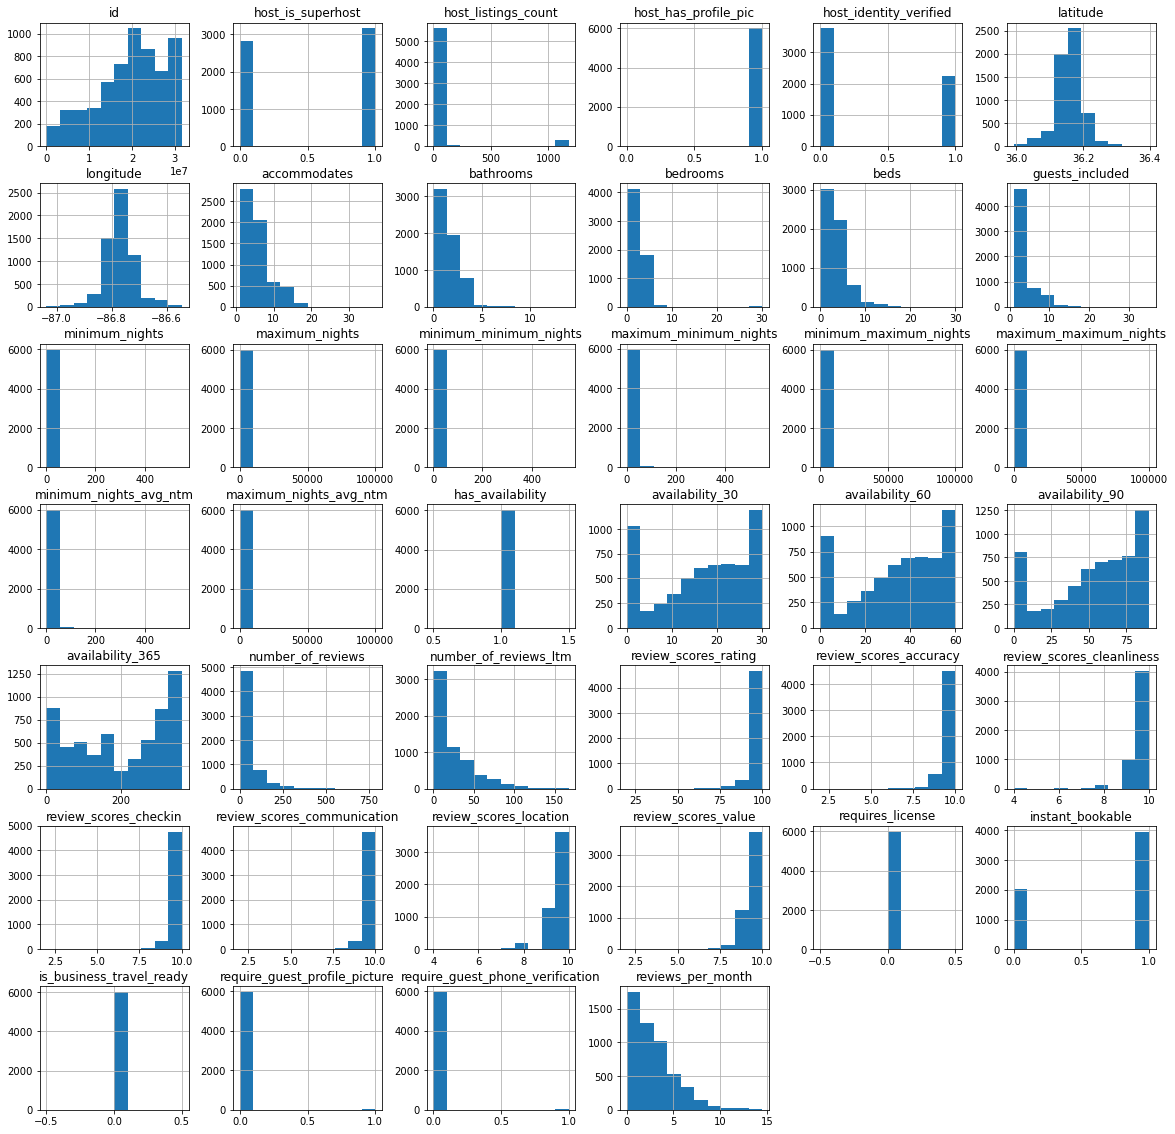

In [10]:
# Replacing columns with f/t with 0/1
list_data_new.replace({'f': 0, 't': 1}, inplace=True)

# Plotting the distribution of numerical and boolean categories
list_data_new.hist(figsize=(20,20))

In [11]:
# Drop columns that only have one value.
list_data_new = list_data_new.drop(columns=['host_has_profile_pic', 'minimum_nights', 'maximum_nights', 'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'has_availability', 'requires_license','is_business_travel_ready'])
list_data_new.shape

(5998, 41)

The team noticed in the initial read in of the dataset that the prices needed to be reformatted to a numeric value. We will remove all '$' and commas and change the value type from string to float values.

In [12]:
# Remove $ and comma from prices and change from string to float
list_data_new['price']=list_data_new['price'].str.replace('$','').str.replace(',','').astype(float)
list_data_new['security_deposit']=list_data_new['security_deposit'].str.replace('$','').str.replace(',','').astype(float)
list_data_new['cleaning_fee']=list_data_new['cleaning_fee'].str.replace('$','').str.replace(',','').astype(float)
list_data_new.head()

<ipython-input-12-f565ecaa4106>:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  list_data_new['price']=list_data_new['price'].str.replace('$','').str.replace(',','').astype(float)
<ipython-input-12-f565ecaa4106>:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  list_data_new['security_deposit']=list_data_new['security_deposit'].str.replace('$','').str.replace(',','').astype(float)
<ipython-input-12-f565ecaa4106>:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  list_data_new['cleaning_fee']=list_data_new['cleaning_fee'].str.

,id,last_scraped,experiences_offered,host_since,host_is_superhost,host_listings_count,host_identity_verified,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,price,security_deposit,cleaning_fee,guests_included,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,reviews_per_month
0,6422,2019-01-17,none,2009-04-03,1,1,1,District 6,36.173151,-86.735813,House,Private room,2,1.0,2,3.0,Real Bed,40.0,NaN,NaN,1,1,7,10,133,561,131,2009-04-30,2019-01-13,99.0,10.0,10.0,10.0,10.0,10.0,10.0,0,strict_14_with_grace_period,0,0,4.74
1,20847,2019-01-17,none,2010-02-08,1,2,0,District 7,36.196397,-86.704267,House,Private room,2,1.0,1,1.0,Real Bed,41.0,0.0,25.0,1,0,0,0,0,138,22,2010-03-14,2018-10-23,94.0,9.0,10.0,9.0,10.0,9.0,9.0,0,strict_14_with_grace_period,1,1,1.28
2,25341,2019-01-17,none,2010-02-08,1,2,0,District 7,36.197053,-86.704937,House,Private room,2,1.0,1,2.0,Real Bed,65.0,0.0,25.0,1,30,60,90,270,102,20,2010-06-14,2018-12-30,96.0,10.0,10.0,10.0,10.0,9.0,9.0,0,strict_14_with_grace_period,1,1,0.97
3,25613,2019-01-17,none,2010-03-18,1,1,1,District 6,36.178263,-86.741622,House,Private room,2,1.0,1,1.0,Real Bed,93.0,NaN,NaN,1,19,35,56,303,454,53,2010-04-25,2019-01-07,97.0,10.0,10.0,10.0,10.0,10.0,10.0,1,moderate,1,1,4.27
4,37306,2019-01-17,none,2010-07-08,0,1,0,District 17,36.133109,-86.774767,House,Private room,2,1.0,1,1.0,Real Bed,105.0,200.0,0.0,1,10,39,69,69,100,1,2010-08-08,2018-11-11,99.0,10.0,10.0,10.0,10.0,10.0,10.0,0,strict_14_with_grace_period,1,1,0.97


### Cleaning individual columns

Becuase 'beds' and several review columns had NaN values in the analysis above, the team wants to take a further look into each of those columns individually.  Starting with beds, we see that the column is good data and we don't want to lose the whole column so we will only delete the 2 rows with NaN's.  

In [13]:
# View value counts for beds
list_data_new['beds'].value_counts()

2.0     1524
1.0     1421
3.0     1133
4.0      675
5.0      408
6.0      282
7.0      160
8.0      120
0.0       73
9.0       44
10.0      39
12.0      31
11.0      27
13.0      21
16.0      12
14.0      10
15.0       4
20.0       3
18.0       3
17.0       1
26.0       1
25.0       1
21.0       1
24.0       1
30.0       1
Name: beds, dtype: int64

In [14]:
# Drop two listings where beds are NaN
list_data_new = list_data_new.dropna(subset=['beds'])
list_data_new.shape

(5996, 41)

From looking at the histograms above, the team can see that the review columns with NaN values don't appear to have many, if any 0 scores.  A quick check of 'review_scores_rating' confirms that there are no 0 values so all of the NaN values will be set to 0.

In [15]:
# View value counts of review_scores_rating
list_data_new['review_scores_rating'].value_counts()

100.0    1501
99.0      826
98.0      702
97.0      504
96.0      364
95.0      266
93.0      194
94.0      192
90.0      120
92.0      117
80.0       81
91.0       69
89.0       46
88.0       37
87.0       34
84.0       17
85.0       15
86.0       14
60.0       10
83.0       10
70.0       10
82.0        5
73.0        5
78.0        4
75.0        4
76.0        3
50.0        2
40.0        2
65.0        2
77.0        1
74.0        1
81.0        1
20.0        1
56.0        1
Name: review_scores_rating, dtype: int64

In [16]:
# replace all NaNs in review columns with 0 - note there are no real 0 reviews and there is a variable is_review to identify the fake 0 values
cols=['review_scores_value','review_scores_location','review_scores_checkin','review_scores_communication','review_scores_cleanliness','review_scores_rating','reviews_per_month','review_scores_accuracy']
list_data_new[cols]=list_data_new[cols].fillna(0)

In [17]:
# View the dataframe
list_data_new.head()

,id,last_scraped,experiences_offered,host_since,host_is_superhost,host_listings_count,host_identity_verified,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,price,security_deposit,cleaning_fee,guests_included,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,reviews_per_month
0,6422,2019-01-17,none,2009-04-03,1,1,1,District 6,36.173151,-86.735813,House,Private room,2,1.0,2,3.0,Real Bed,40.0,NaN,NaN,1,1,7,10,133,561,131,2009-04-30,2019-01-13,99.0,10.0,10.0,10.0,10.0,10.0,10.0,0,strict_14_with_grace_period,0,0,4.74
1,20847,2019-01-17,none,2010-02-08,1,2,0,District 7,36.196397,-86.704267,House,Private room,2,1.0,1,1.0,Real Bed,41.0,0.0,25.0,1,0,0,0,0,138,22,2010-03-14,2018-10-23,94.0,9.0,10.0,9.0,10.0,9.0,9.0,0,strict_14_with_grace_period,1,1,1.28
2,25341,2019-01-17,none,2010-02-08,1,2,0,District 7,36.197053,-86.704937,House,Private room,2,1.0,1,2.0,Real Bed,65.0,0.0,25.0,1,30,60,90,270,102,20,2010-06-14,2018-12-30,96.0,10.0,10.0,10.0,10.0,9.0,9.0,0,strict_14_with_grace_period,1,1,0.97
3,25613,2019-01-17,none,2010-03-18,1,1,1,District 6,36.178263,-86.741622,House,Private room,2,1.0,1,1.0,Real Bed,93.0,NaN,NaN,1,19,35,56,303,454,53,2010-04-25,2019-01-07,97.0,10.0,10.0,10.0,10.0,10.0,10.0,1,moderate,1,1,4.27
4,37306,2019-01-17,none,2010-07-08,0,1,0,District 17,36.133109,-86.774767,House,Private room,2,1.0,1,1.0,Real Bed,105.0,200.0,0.0,1,10,39,69,69,100,1,2010-08-08,2018-11-11,99.0,10.0,10.0,10.0,10.0,10.0,10.0,0,strict_14_with_grace_period,1,1,0.97


Check the values of experiences_offered.  This column wasn't picked up in the histograms becuase it is a string column but all of the listings have the same value of 'none' so the team will drop this column.

In [18]:
# Check values of experiences_offered
list_data_new['experiences_offered'].value_counts()

none    5996
Name: experiences_offered, dtype: int64

In [19]:
# Drop the experiences_offered column
list_data_new = list_data_new.drop(columns=['experiences_offered'])

There are also some date columns remaining in the data that don't tell us much on their own. However, we can use host_since and last_scraped to calculate a new column called days_host to show how many days the lister has been a host at the time the data was scraped.  The last_scraped and host_since columns will then be deleted.

In [20]:
# add new variable called "days_host" which is a calculated value of the difference between the scrape date and the host_since date
list_data_new[['last_scraped', 'host_since']] = list_data_new[['last_scraped', 'host_since']].apply(pd.to_datetime)  # if conversion required
list_data_new['days_host'] = (list_data_new['last_scraped'] - list_data_new['host_since']).dt.days
list_data_new = list_data_new.drop(columns=['last_scraped', 'host_since'])

In [22]:
# View how many NaNs are in each column.
list_data_new.columns.tolist()

['id',
 'last_scraped',
 'host_since',
 'host_is_superhost',
 'host_listings_count',
 'host_identity_verified',
 'neighbourhood_cleansed',
 'latitude',
 'longitude',
 'property_type',
 'room_type',
 'accommodates',
 'bathrooms',
 'bedrooms',
 'beds',
 'bed_type',
 'price',
 'security_deposit',
 'cleaning_fee',
 'guests_included',
 'availability_30',
 'availability_60',
 'availability_90',
 'availability_365',
 'number_of_reviews',
 'number_of_reviews_ltm',
 'first_review',
 'last_review',
 'review_scores_rating',
 'review_scores_accuracy',
 'review_scores_cleanliness',
 'review_scores_checkin',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_value',
 'instant_bookable',
 'cancellation_policy',
 'require_guest_profile_picture',
 'require_guest_phone_verification',
 'reviews_per_month',
 'days_host']

In [ ]:
calendar_data = pd.read_csv("Resources/calendar.csv")